## Introduction and Quick Summery
This script explores trend/seasonality in sales data and runs stationarity checks (Augmented Dickey‑Fuller tests) on the dependent and driver series—an essential sanity step before Marketing Mix Modeling (MMM). Stationary inputs help classical time‑series or regression‑based MMM avoid spurious correlations and unstable coefficients.

- **STEP 1. Imports & Plot Defaults** ... Bring in tools for decomposition (STL) and unit‑root testing (ADF) plus readable Japanese labels.
- **STEP 2. Load monthly data** ... Gives a quick high‑level sense of business growth and seasonality.
- **STEP 3. Create Year/Month columns** ... Enables yearly aggregation and faceted plots.
- **STEP 4. Yearly total‐sales bar chart** ... Shows macro trend—are we growing, flat, or shrinking?
- **STEP 5. Monthly sales by year line plot** ... Reveals intra‑year seasonality and YoY pattern shifts.
- **STEP 6. 2023 drill‑down (4 mini‑plots)** ... Lets you eyeball contemporaneous relationships before modeling.
- **STEP 7. Load weekly data** ... Weekly frequency is common for MMM; last ~5 years selected (data_term).
- **STEP 8. Load weekly data** ... Separate long‑term growth from week‑in‑year seasonality; resid is what MMM ultimately explains.
- **STEP 9. Plot original / trend / seasonal / resid** ... Quick visual QA: trend smooth? seasonal repeating? residual mostly noise?
- **STEP 10. ADF test on resid** ... Checks if residuals are stationary (null = unit root).
- **STEP 11. ADF tests on each media variable** ... Confirms drivers are (or aren’t) stationary—non‑stationary series may require differencing or elasticities‑style transforms before regression.

# Dependencies & Constants

In [7]:
# ── Imports ──────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import japanize_matplotlib  # enables Japanese labels in plots

# ── Global plot style ────────────────────────────────────────────────
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["font.size"] = 10

# ── Constants ────────────────────────────────────────────────────────
YEAR_WEEKS   = 52          # number of observations per year in weekly data
HORIZON_YEARS = 5          # look‑back horizon for MMM
DATA_TERM    = int(YEAR_WEEKS * HORIZON_YEARS)

# Load Monthly Data & Quick EDA

A quick visual pass shows growth and repeating seasonal peaks—useful
context before decomposition.

In [8]:
# 1️⃣ Read monthly time‑series
df_m = (
    pd.read_csv("df_mmm.csv",
                index_col="month",
                parse_dates=True)
      .rename_axis("Month")
)
df_m.index = df_m.index.to_period("M")   # PeriodIndex improves resampling

# 2️⃣ Year / month helper columns
df_m["Year"]  = df_m.index.year
df_m["Month"] = df_m.index.month

print("Monthly data head:\n", df_m.head(), "\n")

Monthly data head:
                sales  traditional   internet  promotional  Year  Month
Month                                                                 
2016-01   4030283000    426400000  666900000    650475000  2016      1
2016-02   5334600000    465450000  657450000    434325000  2016      2
2016-03   3356769000   1119000000          0    404475000  2016      3
2016-04   5004399000    926500000  613725000    197400000  2016      4
2016-05  11650794000   1523800000  699675000    157162500  2016      5 



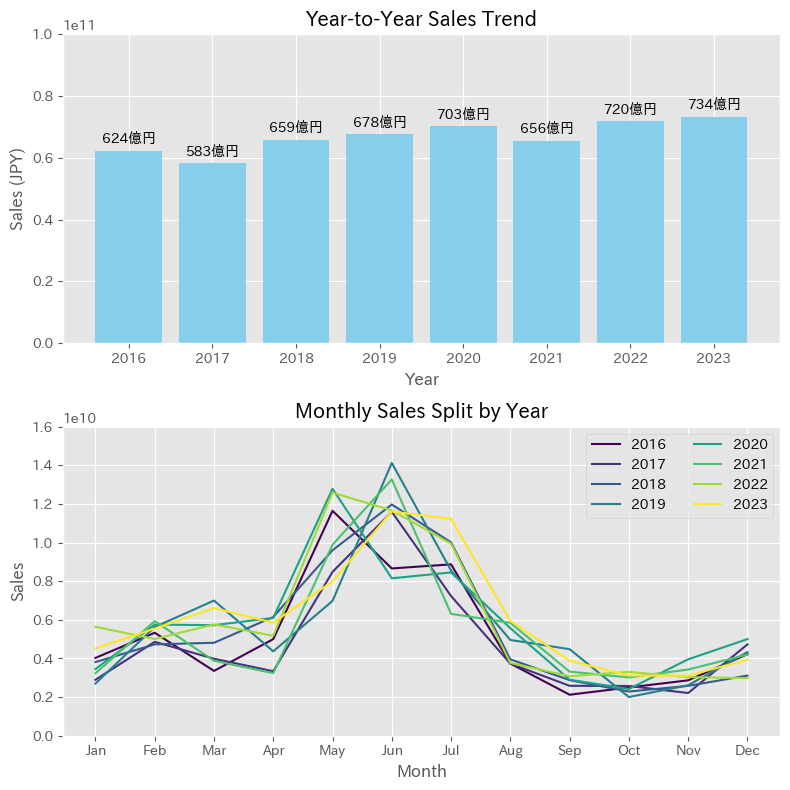

In [10]:
# 3️⃣ Yearly total sales bar chart
df_yearly_sales = df_m.groupby("Year")["sales"].sum()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# ── 3‑A Yearly trend
bars = ax[0].bar(df_yearly_sales.index,
                 df_yearly_sales.values,
                 color="skyblue")
for r in bars:
    height = r.get_height()
    ax[0].annotate(f"{height/1e8:.0f}億円",
                   xy=(r.get_x() + r.get_width()/2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha="center", va="bottom")
ax[0].set(title="Year‑to‑Year Sales Trend",
          xlabel="Year", ylabel="Sales (JPY)")
ax[0].set_ylim(0, 1e11)
# ── 3‑B Intra‑year seasonality by year
years  = df_m["Year"].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))
for c, yr in zip(colors, years):
    df_year = df_m[df_m["Year"] == yr]
    ax[1].plot(df_year["Month"], df_year["sales"],
               label=str(yr), color=c)
ax[1].set(title="Monthly Sales Split by Year",
          xlabel="Month", ylabel="Sales")
ax[1].set_xticks(range(1, 13))
ax[1].set_ylim(0, 1.6e10)
ax[1].legend(ncol=2)
ax[1].set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
     "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.tight_layout()
plt.show()

## Insight
- Sales tend to increase around June.

## Hypothesis
- Because people begin taking measures against the heat in June, air-conditioner sales tend to rise in that month. 
- Air-conditioner sales are heavily influenced by seasonal factors.

# 2023 Focus: Sales vs. Three Media Channels
Side‑by‑side lines help eyeball any obvious contemporaneous patterns
(e.g., bursts of spend vs. sales spikes).

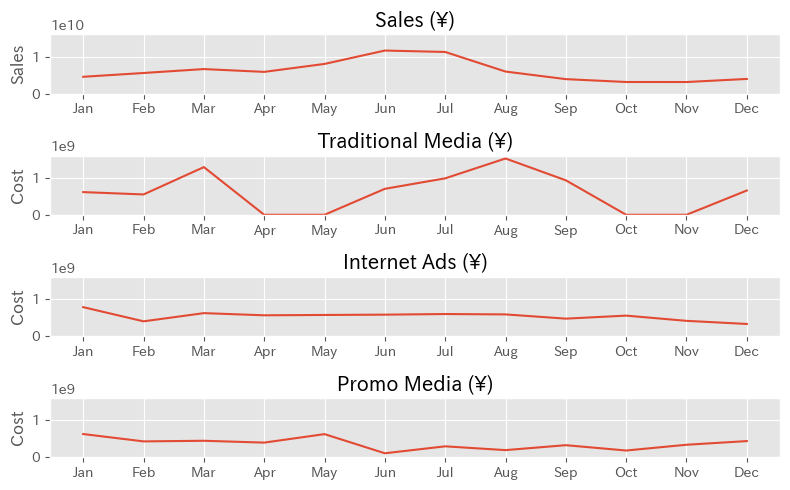

In [25]:
df_2023 = df_m.loc['2023']
total_rows = 4
fig, axes = plt.subplots(nrows=total_rows, ncols=1, figsize=(8, 5))

graph_info = [
    ("Sales (¥)",            "sales",   'Sales',     1.6e10),
    ("Traditional Media (¥)","traditional", 'Cost', 1.6e9),
    ("Internet Ads (¥)",     "internet",  'Cost',   1.6e9),
    ("Promo Media (¥)",      "promotional", 'Cost',1.6e9),
]

for ax, (title, column, ylabel, ylim) in zip(axes, graph_info):
    ax.set_title(title)
    ax.plot(df_2023['Month'], df_2023[column])
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(1, 13))
    ax.set_ylim(0, ylim)
    ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

plt.tight_layout()
plt.show()

## Question
- Air-conditioner TV commercials, despite their high cost, might not be contributing to sales?
- Sales are influenced by a variety of other factors as well—two types of advertising besides TV commercials, seasonal effects… and so on.
- Also, this graph covers only a single year, 2023.
- To truly unravel this “mystery,” a deeper analysis with much more data is required!

# Load Weekly Data & Define Dep/Indep Vars



Classical MMMs usually work on weekly panels.
Here we just select the latest 5 years to keep model run‑time down.

In [26]:
# 3️⃣ Read weekly time‑series
df_w = pd.read_csv("MMM_ts_manga5.csv",
                   index_col="week",
                   parse_dates=True)
print("Weekly data head:\n", df_w.head(), "\n")

# 4️⃣ Slice the most recent horizon (≈5 years)
X = df_w.drop(columns=["sales"]).iloc[-DATA_TERM:]
y = df_w["sales"].iloc[-DATA_TERM:]


Weekly data head:
                 sales  traditional   internet  promotional
week                                                      
2015-12-27  649315000    656100000          0            0
2016-01-03  958266000            0  178050000    188587500
2016-01-10  755973000            0  150450000    162037500
2016-01-17  551603000            0          0    126900000
2016-01-24  520183000            0  175500000            0 



# STL Decomposition of Weekly Sales
Removing long‑term growth and annual cycles isolates the noise
(residuals) your drivers should explain.
Big leftover patterns signal missing variables or structural breaks.

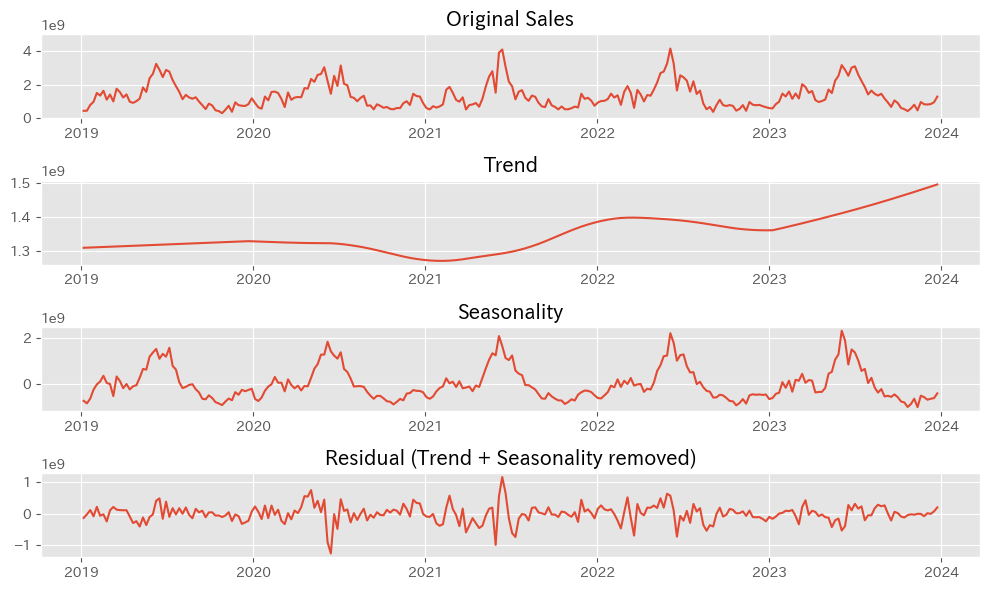

In [27]:
# STL uses a seasonal period of 52 weeks (≈1 year)
stl = STL(y, period=YEAR_WEEKS)
res  = stl.fit()

trend, seasonal, resid = res.trend, res.seasonal, res.resid

# ── Plot
plt.figure(figsize=(10, 6))
plt.subplot(4,1,1); plt.plot(y.index, y);       plt.title("Original Sales"); plt.ylim(0, 5e9)
plt.subplot(4,1,2); plt.plot(y.index, trend);    plt.title("Trend")
plt.subplot(4,1,3); plt.plot(y.index, seasonal); plt.title("Seasonality")
plt.subplot(4,1,4); plt.plot(y.index, resid);    plt.title("Residual (Trend + Seasonality removed)")
plt.tight_layout(); plt.show()


## Insight
1. Trend Analysis
The underlying trend exhibits a modest upward trajectory over the observed period.

2. Seasonal Pattern
Seasonal effects are particularly pronounced in June, where a clear sales peak is evident.

3. Residual Component
The residual component represents variability that cannot be attributed to either trend or seasonality. It encompasses influences such as advertising campaigns, promotional activities, and competitor actions. These factors manifest within the residuals and are critical for understanding additional drivers of sales performance.

Because the residual component captures these “unknown” or external influences, it warrants close examination. The first step is to confirm that the residual series is stationary, ensuring that subsequent analyses (e.g., forecasting or intervention detection) will be reliable.

# Augmented Dickey‑Fuller (ADF) Stationarity Tests
- If p_value < 0.05 and test_stat is below the 5 % critical value,
the series is stationary → OK to use as‑is.
- Otherwise, consider differencing, log‑returns, or ad‑stock transforms
before feeding into a regression.

In [28]:
def run_adf(series: pd.Series, name: str) -> pd.Series:
    """Return ADF statistics in a tidy Series."""
    stat, p, _, _, crit, _ = adfuller(series)
    out = {"test_stat": stat, "p_value": p}
    out.update({f"cv_{k}%": v for k, v in crit.items()})
    return pd.Series(out, name=name)

# 5‑A Residuals of sales (should be stationary if STL did its job)
resid_adf = run_adf(resid, "sales_resid")
print("\nADF result – Sales residuals\n", resid_adf, "\n")

# 5‑B Each driver
driver_adf = pd.concat([run_adf(X[col], col) for col in X.columns])
print("ADF results – Drivers\n", driver_adf, "\n")



ADF result – Sales residuals
 test_stat   -1.154057e+01
p_value      3.643016e-21
cv_1%%      -3.455853e+00
cv_5%%      -2.872765e+00
cv_10%%     -2.572752e+00
Name: sales_resid, dtype: float64 

ADF results – Drivers
 test_stat   -1.015916e+01
p_value      7.588243e-18
cv_1%%      -3.455953e+00
cv_5%%      -2.872809e+00
cv_10%%     -2.572775e+00
test_stat   -1.570584e+01
p_value      1.378305e-28
cv_1%%      -3.455853e+00
cv_5%%      -2.872765e+00
cv_10%%     -2.572752e+00
test_stat   -5.416546e+00
p_value      3.126440e-06
cv_1%%      -3.457215e+00
cv_5%%      -2.873362e+00
cv_10%%     -2.573070e+00
dtype: float64 



## ADFテストをざっくり説明すると
- **何をする？** ... 時系列が “フラフラ漂っていない” (= 定常か) をチェックします。
- **コードの流れ** ...1. run_adf() でシリーズを渡す、 2.ADFテストを実行し、test_stat (= 検定統計量)、p_value (= 有意確率)、cv_1%/5%/10% (= 臨界値)を返すだけ。
- **合否ライン**	... p_value < 0.05 かつtest_stat が 臨界値 より小さい (＝左側) ⇒ 定常 OK → そのまま回帰に使える。それ以外 ⇒ 非定常 → 差分を取る・対数変化・アドストック化などの前処理が必要

**今回の結果をチェック**

売上残差
- test_stat：-11.54
- 5 % 臨界値：-2.87
- p_value：3.6e-21
- 判定：定常 ✅

Driver 1
- test_stat：-10.16
- 5 % 臨界値：-2.87
- p_value：7.6e-18
- 判定：定常 ✅

Driver 2
- test_stat：-15.71
- 5 % 臨界値：-2.87
- p_value：1.4e-28
- 判定：定常 ✅

Driver 3
- test_stat：-5.42
- 5 % 臨界値：-2.87
- p_value：3.1e-06
- 判定：定常 ✅

結果 → 定常 ✅
- すべての p_value が 0.05 より十分に小さい
- いずれの test_stat も 5 % 臨界値よりかなり左（数値が小さい）に位置
→ 全シリーズが定常と判定
- 追加の差分や対数変換は不要
→ このまま MMM 回帰に進めて問題ありません。